In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: Qt4Agg


# SA(2) invariant signatures
We are considering transformations in $SA(2)$ of the following form:

\begin{equation}
   \hat{x}_i = a_{ij} x_j + b_i
\end{equation}

where $\det a = 1$, or in vector notation $\hat{x} = Ax + b$, $\det A = 1$. Our image $f : \mathbb{R}^2 \mapsto \mathbb{R}$ transforms as $f(x) = \hat{f}(\hat{x})$. Then, we have the following:

\begin{align}
    f_{,i} &= \hat{f}_{,k}a_{ki}, & \nabla{f} &= A^T \nabla{\hat{f}} \\
    f_{,ij} &= \hat{f}_{,kl} a_{ki} a_{lj} & \nabla^2 f &= A^T \nabla^2 \hat{f} A
\end{align}

We can see that in vector notation, we have the following invariants under SA(2) (at $x$ on the left and $\hat{x}$ on the right:
1. $I_0 = f(x) = \hat{f}(\hat{x})$
2. $I_1 = \det \nabla^2 f(x) = \det(A^T)\det \nabla^2 \hat{f} \det(A) = \det \nabla^2 \hat{f}$
3. $I_2 =(\nabla f)^T (\nabla^2 f)^{-1} (\nabla f) = (\nabla \hat{f})^T A A^{-1} (\nabla^2 \hat{f})^{-1} A^{-T} A^T \nabla{\hat f} = (\nabla \hat{f})^T (\nabla^2 \hat{f})^{-1} \nabla \hat{f}$

The third invariant is in fact invariant under $A(2)$, not just $SA(2)$. However, for $SA(2)$ we can replace it with a polynomial by multiplying by $\det \nabla^2 f$, in which case $(\nabla^2 f)^{-1}$ is replaced by $\text{adj} \nabla^2 f$.

3a. $I_2 = (\nabla f)^T \text{adj} \nabla^2 f \nabla f = f_{yy} f_x^2 - 2f_{xy}f_x f_y + f_{xx} f_y^2 $

## Update: transvectants
Let's also check to see whether Robert's transvectant formulae also work (the first two being ones we already know):
1. $f_{xx} f_{yy} - f_{xy}^2$
2. $f_y^2 f_{xx} - 2f_x f_y f_{xy} + f_x^2 f_{yy}$
3. $f_{yy} f_{xxy}^2 - f_{yy} f_{xxx} f_{xyy} - f_{xy} f_{xxy} f_{xyy} + f_{xx} f_{xyy}^2 + f_{xy} f_{xxx} f_{yyy} - f_{xx} f_{xxy} f_{yyy}$
4. $f_y f_{yy} f_{xxx} - 2f_y f_{xy} f_{xxy} - f_x f_{yy} f_{xxy} + f_y  f_{xx} f_{xyy} + 2f_x f_{xy} f_{xyy} - f_x  f_{xx} f_{yyy}$

In [3]:
def SA2signature(F, h=1):
    """ All the degree three and lower transvectants"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    Fxxx, Fxxy = np.gradient(Fxx, h)
    Fxyx, Fxyy = np.gradient(Fxy, h)
    Fyyx, Fyyy = np.gradient(Fyy, h)
    
    I0 = F
    I1 = Fxx*Fyy - Fxy**2
    I2 = Fy**2*Fxx - 2*Fx*Fy*Fxy + Fx**2*Fyy
    I3 = Fyy*Fxxy**2 - Fyy*Fxxx*Fxyy - Fxy*Fxxy*Fxyy + Fxx*Fxyy**2 + Fxy*Fxxx*Fyyy - Fxx*Fxxy*Fyyy
    I4 = Fy*Fyy*Fxxx - 2*Fy*Fxy*Fxxy - Fx*Fyy*Fxxy + Fy*Fxx*Fxyy + 2*Fx*Fxy*Fxyy - Fx*Fxx*Fyyy
    
    return np.array((I0, I1, I2, I3, I4))

def SE2signature(F, h=1):
    """ Compute equiaffine-invariant image signature using finite differences"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    
    I0 = F # function value
    I1 = Fx*Fx + Fy*Fy
    I2 = Fxx + Fyy
    return np.array((I0, I1, I2))

## Currents

The currents formulae are defined below. Currently quick and dirty, needs some spit and polish.


In [2]:
def signed_area(ax, ay, bx, by, cx, cy):
    """ Compute signed area of a triangle

    Arguments:
    ax, ay, bx, by, cx, cy -- the x and y coordinates of the (ordered)
    vertices a, b, c of the triangle
    """
    return 0.5*(ax*by - ay*bx + bx*cy - by*cx + cx*ay - cy*ax)

def triangle_areas(X, Y):
    """ Compute signed area of triangulation of gridded mesh

    Arguments:
    X, Y -- 2D arrays of X, Y coordinates. Each grid square is split into
    two triangles and the oriented area computed
    """

    ax, ay = X[0:-1, 0:-1], Y[0:-1, 0:-1]
    bx, by = X[0:-1, 1:], Y[0:-1, 1:]
    cx, cy = X[1:, 0:-1], Y[1:, 0:-1]
    dx, dy = X[1:, 1:], Y[1:, 1:]
    
    # lower is triangle ACD, upper is triangle ADB (anticlockwise
    # orientation) if indices of X and Y are drawn as matrix rows/ columns
    lower = signed_area(ax, ay, cx, cy, dx, dy)
    upper = signed_area(ax, ay, dx, dy, bx, by)
        
    return lower, upper

def compute_centroids(I):
    """ Compute mean value of a quantity on a grid subdivided into
    triangles

    """
    lower = 1./3. * (I[0:-1, 0:-1] + I[1:, 0:-1] + I[1:, 1:])
    upper = 1./3. * (I[0:-1, 0:-1] + I[1:, 1:] + I[0:-1, 1:])
    return lower, upper

class InvariantSurface():
    def __init__(self, I0, I1, I2):
        self.centroids = [compute_centroids(I) for I in (I0, I1, I2)]
    
        self.dxdy_l, self.dxdy_u = triangle_areas(I0, I1)
        self.dydz_l, self.dydz_u = triangle_areas(I1, I2)
        self.dxdz_l, self.dxdz_u = triangle_areas(I2, I0)

    def current(self, m, n, k):
        integrand_l = (self.centroids[0][0]**m * 
                self.centroids[1][0]**n *
                self.centroids[2][0]**k)
        integrand_u = (self.centroids[0][1]**m * 
                self.centroids[1][1]**n *
                self.centroids[2][1]**k)
        
        return np.array([
            (integrand_l*self.dxdy_l + integrand_u*self.dxdy_u).sum(),
            (integrand_l*self.dydz_l + integrand_u*self.dydz_u).sum(),
            (integrand_l*self.dxdz_l + integrand_u*self.dxdz_u).sum()])


## Random Transformations
We generate a random equiaffine transformation $x \mapsto Ax + b$, $\det A = 1$ using the `RandomEquiaffine` class, and we generate random noise by adding on some random trigonometric terms. The noise should be done more nicely by specifying a PSD, and then inverting the Fourier transform, but my brain was hurting. Marking this as a TODO.


In [4]:
from numpy.random import rand, randn
import numpy.random
from scipy.fftpack import ifft2, idct, dct

class RandomEquiaffine():
    def __init__(self):
        theta = 2*np.pi*np.random.rand();
        self.A =  np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]) + np.random.rand(2,2)
        if np.linalg.det(self.A) < 0:
            self.A[:, 1] = -self.A[:, 1]
        self.A = self.A / np.sqrt(np.linalg.det(self.A))
        self.b = 0.1 * randn(2)
        self.Ainv = np.linalg.inv(self.A)
        self.binv = -np.linalg.solve(self.A, self.b)
    
    def forward_transform(self, f, X, Y):
        return f(self.Ainv[0,0]*X + self.Ainv[0,1]*Y + self.binv[0], 
                 self.Ainv[1,0]*X + self.Ainv[1,1]*Y + self.binv[1])

class RandomSE2():
    def __init__(self):
        theta = 2*np.pi*np.random.rand();
        self.A =  np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        self.b = 0.1 * randn(2)
        self.Ainv = self.A.T
        self.binv = -np.linalg.solve(self.A, self.b)
    
    def forward_transform(self, f, X, Y):
        return f(self.Ainv[0,0]*X + self.Ainv[0,1]*Y + self.binv[0], 
                 self.Ainv[1,0]*X + self.Ainv[1,1]*Y + self.binv[1])

def smooth_noise(shape, width=1, decay=100):
    m, n = shape
    m_freq = np.arange(m) / m
    n_freq = np.arange(n) / n
    Mf, Nf = np.meshgrid(n_freq, m_freq)
    
    W = width*numpy.random.standard_normal(shape) * np.exp(-decay*(Mf + Nf))
    W[0,0] = 0
    
    X = idct(idct(W, axis=0), axis=1)    
    return X

In [46]:
plt.imshow(smooth_noise((100, 200), decay=100))

# Numerical Experiments
First, let's define the function we'll use, and a convenience function to compute the three currents for a given integrand $x^m y^n z^k$

In [5]:
def f(x, y):
    return 0.5*(1 + np.sin(4*x) * np.cos(7*y)) * 2*np.exp(-10*((x - 0.1)**2 + (y+0.2)**2))

def compute_current(h, m, n, k):
    X, Y = np.meshgrid(np.arange(-1.5, 1.5, h), np.arange(-1.5, 1.5, h))
    F = f(X, Y)
    sig = SA2signature(F, h)
    surf = InvariantSurface(sig[0], sig[1], sig[2])
    return surf.current(m, n, k)


## Check certain integrals are zero:
We have a closed surface, so the following integrals should be zero:
* $\int dx dy, \int dy dz, \int dx dz $,
* $\int x dx dy, \int x dx dz $,
* $\int y dx dy, \int y dy dz $,
* $\int z dx dz, \int z dy dz $.

In [10]:
h = 0.01
print(compute_current(h, 0, 0, 0))
print(compute_current(h, 1, 0, 0))
print(compute_current(h, 0, 1, 0))
print(compute_current(h, 0, 0, 1))

[  8.25838286e-13  -6.68337983e-11   1.65974503e-13]
[  9.55908367e-13   2.12623888e+04   1.62855789e-13]
[  1.24838057e-09  -1.12772640e-07   2.12623888e+04]
[  2.12623888e+04  -5.53441631e-08  -1.05063408e-10]


## Check convergence of current

In [11]:
m, n, k = 1, 1, 1
h = 0.05
print('Relative error in: int x^{:d} y^{:d} z^{:d} dx dy:'.format(m, n, k))
print('-----------------------------------------')
print('h         relerr')
x0 = compute_current(h, m, n, k)[0]
for i in range(6):
    h = h/2
    x1 = compute_current(h, m, n, k)[0]
    print('{:f}  {:f}'.format(h, np.abs(x1 - x0) / np.abs(x0)))
    x0 = x1
print('int x^{:d} y^{:d} z^{:d} dx dy = {:f}'.format(m, n, k, x1))


Relative error in: int x^1 y^1 z^1 dx dy:
-----------------------------------------
h         relerr
0.025000  0.285775
0.012500  0.210483
0.006250  0.078329
0.003125  0.022098
0.001563  0.005705
0.000781  0.001438
int x^1 y^1 z^1 dx dy = 740106.958978


## Convergence of currents under random transformation

In [16]:

from numpy.linalg import norm
def compute_currents_tformed(h, tform, m, n, k):
    X, Y = np.meshgrid(np.arange(-1.5, 1.5, h), np.arange(-1.5, 1.5, h))
    F0 = f(X, Y)
    F1 = tform.forward_transform(f, X, Y)
    sig0 = SA2signature(F0, h)
    sig1 = SA2signature(F1, h)
    surf0 = InvariantSurface(sig0[0], sig0[1], sig0[2])
    surf1 = InvariantSurface(sig1[0], sig1[1], sig1[2])
    c0 = surf0.current(m, n, k)
    c1 = surf1.current(m, n, k)
    return c0, c1
    

tform = RandomSE2()
m, n, k = 1, 1, 1
h = 0.05
print('h         relerr')
print('------------------')
for i in range(6):
    c0, c1 = compute_currents_tformed(h, tform, m, n, k)
    err = norm(c0 - c1) / norm(c0)
    print('{:f}  {:f}'.format(h, err))
    h = h/2
print(c0)
print(c1)
    

    

h         relerr
------------------
0.050000  0.003170
0.025000  0.004502
0.012500  0.001608
0.006250  0.000443
0.003125  0.000113
0.001563  0.000029
[  7.41172645e+05  -5.52219382e+08  -3.13565466e+06]
[  7.41190470e+05  -5.52235145e+08  -3.13564697e+06]


In [9]:
h = 0.005
c = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            c.append(compute_current(h, i, j, k))
            #print('int x^{:d} y^{:d} z^{:d} dxdy = {:g}'.format(i, j, k, c[0]))
            #print('int x^{:d} y^{:d} z^{:d} dydz = {:g}'.format(i, j, k, c[1]))
            #print('int x^{:d} y^{:d} z^{:d} dzdx = {:g}'.format(i, j, k, c[2]))
c = np.array(c)

In [140]:
# Define an image function and another similar looking function
def f(x, y):
    return 0.5*(1 + np.sin(4*x) * np.cos(7*y)) * 2*np.exp(-10*((x - 0.1)**2 + (y+0.2)**2))

def g(x, y):
    return 0.5*(1 + np.sin(5*x) * np.cos(6*y)) * 2*np.exp(-12*((x - 0.1)**2 + (y+0.2)**2))

# Repeat: add noise to each image and compute signatures
# Compute currents, add to array
h = 0.005
X, Y = np.meshgrid(np.arange(-1.5, 1.5, h), np.arange(-1.5, 1.5, h))

F = f(X, Y)
G = g(X, Y)
N = 2
# Make smooth noise for each image
width = 1e-2
def expt(width, F, G, h, N=N):
    W_f = smooth_noise(shape=F.shape, width=width)
    W_g = smooth_noise(shape=G.shape, width=width)

    sig_f = SA2signature(F + W_f, h)
    sig_g = SA2signature(G + W_g, h)
    for i in range(1, 3):
        sig_f[i] = np.arctan(sig_f[i] / 100) #100 for SE2
        sig_g[i] = np.arctan(sig_g[i] / 100) #100 for SE2

    surf_f = InvariantSurface(sig_f[0], sig_f[1], sig_f[2])
    surf_g = InvariantSurface(sig_g[0], sig_g[1], sig_g[2])

    c_f = np.zeros(3*(N+1)**3)
    c_g = np.zeros(3*(N+1)**3)
    count = 0
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                c_f[count:count+3] = surf_f.current(i, j, k)
                c_g[count:count+3] = surf_g.current(i, j, k)
                count = count + 3
            
    return c_f, c_g




In [141]:
C_F = []
C_G = []
for i in range(20):
    c_f, c_g = expt(width, F, G, h)
    C_F.append(c_f)
    C_G.append(c_g)
C_F = np.array(C_F).T
C_G = np.array(C_G).T

In [142]:
sig1 = SA2signature(F, h)
sig2 = SA2signature(G, h)
for i in range(1, 3):
    sig1[i] = np.arctan(sig1[i] / 100)
    sig2[i] = np.arctan(sig2[i] / 100)

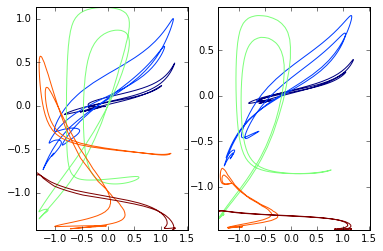

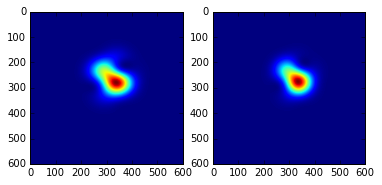

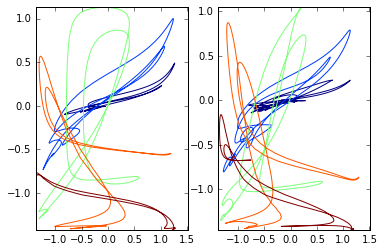

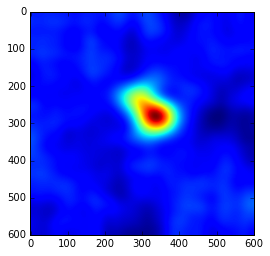

In [143]:
levels = [0.1, 0.25, 0.5, 0.75, 0.9]
plt.subplot(1,2,1)
plt.contour(sig1[1], sig1[2], sig1[0], levels=levels )
plt.subplot(1,2,2)
plt.contour(sig2[1], sig2[2], sig2[0], levels=levels )

plt.figure()
plt.subplot(1,2,1)
plt.imshow(F)
plt.subplot(1,2,2)
plt.imshow(G)


W = smooth_noise(F.shape, width=width)
sig = SA2signature(F + W, h)
for i in range(1, 3):
    sig[i] = np.arctan(sig[i] / 100)
    

plt.figure()
plt.subplot(1,2,1)
plt.contour(sig1[1], sig1[2], sig1[0], levels=levels )
plt.subplot(1,2,2)
plt.contour(sig[1], sig[2], sig[0], levels=levels )

plt.figure()
plt.imshow(F + W)

(40, 81)
[ 5.08417331  1.68099862  0.91124923  0.6924298   0.38948705]


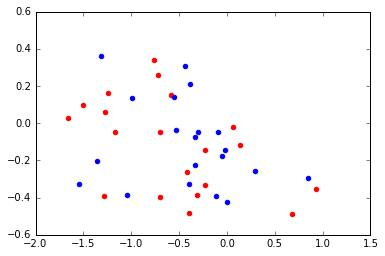

In [144]:
%matplotlib inline
n_transformations = C_F.shape[1]
C = np.hstack((C_F, C_G)).T
print(C.shape)
from scipy.linalg import svd
U, S, Vh = svd(C)
print(S[0:5])
smeg = C.dot(Vh[0:2, :].T)
plt.clf()
plt.scatter(smeg[0:n_transformations,0], smeg[0:n_transformations,1], color='red')
plt.scatter(smeg[n_transformations:,0], smeg[n_transformations:,1], color='blue')


In [ ]:
plt.imshow(f(X, Y), cmap=cm.gray)
imsave('f.jpg', f(X, Y))

In [6]:
# Another scenario to work with
from mpl_toolkits.mplot3d import Axes3D
%matplotlib 


def f_coarse(x, y):
    return np.exp(-x**2 - 1.5*y**2)
def f_fine(x, y):
    return np.exp(-20*(x - 0.5)**2 - 20*(y - 0.4)**2)

h = 0.005
delta = 0.05
X, Y = np.meshgrid(np.arange(-1.5, 1.5, h), np.arange(-1.5, 1.5, h))
plt.figure()
plt.imshow(f_coarse(X, Y) + delta*f_fine(X, Y))

F = f_coarse(X, Y)
G = f_coarse(X, Y) + delta*f_fine(X, Y)

sigfun = SA2signature
sig_F = sigfun(F, h)
sig_G = sigfun(G, h)

levels = np.linspace(0.1, 0.9, 20)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(sig_G[1], sig_G[2], sig_G[0])


Using matplotlib backend: Qt4Agg
